<a href="https://colab.research.google.com/github/rezzie-rich/colab-notebooks/blob/main/Mistral_LoRA_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

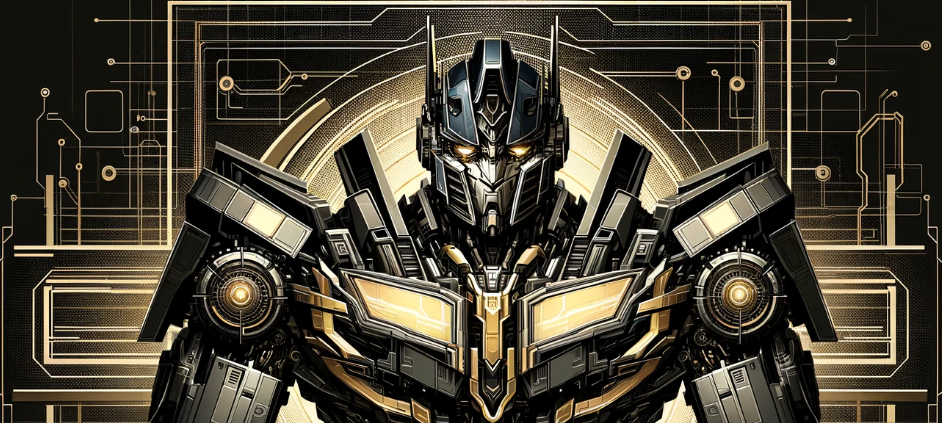

# 🌟 Repair Bay: Advanced AI Model Tuning Suite 🚀

Key Features of Repair Bay:

🤖 Advanced Model Training: Utilize state-of-the-art techniques like LoRA, PEFT, and Hyperparameter Optimization for robust model training.

📈 Optuna Integration: Harness the power of Optuna for extensive hyperparameter tuning, driving your models to their peak performance.

📊 Data Versatility: Seamlessly load and process datasets from various sources, ensuring flexibility and convenience.

🛠️ Custom Callbacks: Implement specialized checkpointing to monitor and save your model's progress at regular intervals.

🔍 Real-Time Debugging: Benefit from comprehensive logging, offering clear insights into the training process.

🚀 Efficient Processing: Experience enhanced efficiency with INT8 quantization and distributed training support.

🌐 Hugging Face Integration: Easy access and version control with direct model pushing to Hugging Face Hub.

📝 User-Friendly Interface: Interactive prompts and structured error handling for an intuitive user experience.

🔄 Continuous Improvement: Regular updates and optimizations to stay at the forefront of AI technology.

In [ ]:
# Install necessary libraries
!pip install -q transformers datasets bitsandbytes-cuda11 peft huggingface_hub optuna pandas trl

In [ ]:
# Modularized and Dynamic Training Script for Mistral 7B with LoRA, PEFT, and Hyperparameter Optimization

import logging
import pandas as pd
import torch
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq,
    trainer_utils
)
from datasets import load_dataset, Dataset
from peft import LoraConfig, prepare_model_for_int8_training, get_peft_model
from sklearn.model_selection import train_test_split
from huggingface_hub import notebook_login

# Authenticate with Hugging Face
notebook_login()

# Setting up logging for debugging and tracking
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Custom Callback for Checkpointing during training
class CustomCheckpointCallback(trainer_utils.Callback):
    def __init__(self, model):
        self.model = model

    def on_step_end(self, args, state, control, **kwargs):
        # Save model at every 100 steps for tracking and potential rollback
        if state.global_step % 100 == 0:
            self.model.save_pretrained(f'{args.output_dir}/checkpoint_{state.global_step}')

# Function Definitions

def input_with_validation(prompt, type_=None, validation=None, error_msg='Invalid input'):
    """Validates and converts user input."""
    while True:
        try:
            value = input(prompt)
            if type_:
                value = type_(value)
            if validation and not validation(value):
                raise ValueError
            return value
        except ValueError:
            print(error_msg)

def initialize_model_and_tokenizer(model_name):
    """Initializes the model and tokenizer."""
    try:
        model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        return model, tokenizer
    except Exception as e:
        logging.error(f"Error initializing model and tokenizer: {e}")
        raise

def configure_lora(model, r, lora_alpha, target_modules, lora_dropout, bias_config):
    """
    Configures LoRA for the model.
    """
    try:
        lora_config = LoraConfig(r=r, lora_alpha=lora_alpha, target_modules=target_modules, lora_dropout=lora_dropout, bias=bias_config)
        # Preparing model for quantized INT8 training for efficiency
        model = prepare_model_for_int8_training(model)
        # Applying PEFT for efficient distributed training
        model = get_peft_model(model, lora_config)
        return model
    except Exception as e:
        logging.error(f"Error configuring LoRA: {e}")
        raise

def load_and_prepare_dataset(dataset_name, text_field, response_field=None, local_path=None, tokenizer=None, max_length=512):
    """
    Loads and prepares the dataset.
    """
    try:
        if local_path:
            dataset = Dataset.from_pandas(pd.read_csv(local_path))
        else:
            dataset = load_dataset(dataset_name, split='train')

        def preprocess_function(examples):
            if response_field:
                text = ['Prompt: ' + ex[text_field] + '\nResponse: ' + ex[response_field] for ex in examples]
            else:
                text = examples[text_field]
            return tokenizer(text, truncation=True, padding='max_length', max_length=max_length)

        dataset = dataset.map(preprocess_function, batched=True)
        return dataset
    except Exception as e:
        logging.error(f"Error loading and preparing dataset: {e}")
        raise

def objective(trial):
    # Defining hyperparameter search space
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    num_train_epochs = trial.suggest_int("num_train_epochs", 3, 10)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    warmup_steps = trial.suggest_int("warmup_steps", 300, 1000)

    # Training arguments
    training_args = TrainingArguments(
        output_dir="output",
        learning_rate=learning_rate,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=batch_size,
        logging_steps=50,
        save_steps=100,
        fp16=True,
        gradient_checkpointing=True,
        evaluation_strategy="epoch",
        warmup_steps=warmup_steps,
        weight_decay=0.01,
        lr_scheduler_type="linear"
    )

    # Initializing Trainer
    data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, label_pad_token_id=-100, pad_to_multiple_of=8)
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        data_collator=data_collator,
        callbacks=[CustomCheckpointCallback(model)]
    )

    # Run training
    trainer.train()

    # Evaluate the model
    results = trainer.evaluate()

    return results["eval_loss"]

# Main Script Execution
def main():
    try:
        # Model and tokenizer initialization
        model_name = input("Enter the model name (e.g., 'mistralai/Mistral-7B-v0.1'): ")
        model, tokenizer = initialize_model_and_tokenizer(model_name)

        # Configuring LoRA parameters
        r = input_with_validation("Enter LoRA rank (e.g., 16): ", int)
        lora_alpha = input_with_validation("Enter LoRA alpha (e.g., 32): ", int)
        target_modules = input("Enter target modules separated by comma (e.g., 'q_proj,k_proj,v_proj,o_proj'): ").split(',')
        lora_dropout = input_with_validation("Enter LoRA dropout rate (e.g., 0.05): ", float)
        bias_config = input("Enter bias configuration ('none' or other): ")
        model = configure_lora(model, r, lora_alpha, target_modules, lora_dropout, bias_config)

        # Dataset loading and preparation
        dataset_name = input("Enter the dataset name (leave blank if using local dataset): ")
        text_field = input("Enter the name of the text field in the dataset: ")
        response_field = input("Enter the name of the response field in the dataset (leave blank if not applicable): ")
        local_path = input("Enter local dataset path (leave blank if using Hugging Face dataset): ")
        dataset = load_and_prepare_dataset(dataset_name, text_field, response_field, local_path, tokenizer)

        # Splitting the dataset into training and testing sets
        train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)

        # Hyperparameter Optimization
        enable_optimization = input_with_validation("Enable hyperparameter optimization? (yes/no): ", str, lambda x: x.lower() in ['yes', 'no'])
        if enable_optimization.lower() == 'yes':
            study = optuna.create_study(direction="minimize")
            study.optimize(objective, n_trials=10)
            best_trial = study.best_trial

            # Printing best hyperparameters
            print(f"Best trial: {best_trial.params}")

        # Train the model with or without hyperparameter optimization
        if enable_optimization.lower() == 'yes':
            # Reinitialize the model with best hyperparameters
            train_model(model, best_trial.params, train_dataset, test_dataset, tokenizer)
        else:
            # Default training
            train_model(model, training_args, train_dataset, test_dataset, tokenizer)

        # Uploading the trained model to Hugging Face for easy access and version control
        model.push_to_hub(f"{model_name}_trained_model")
    except Exception as e:
        logging.error(f"An error occurred in the main script: {e}")

if __name__ == "__main__":
    main()


# 🚀 Navigating the Intricacies of Repair Bay 🌟

Setting the Stage: Initialization and Setup

📚 Library Imports: Our journey begins with importing essential libraries, a foundational step that equips Repair Bay with the diverse functionalities of PyTorch, Optuna, Transformers, and more.

🔑 Authentication: Seamlessly connect to the Hugging Face Hub, ensuring your work is securely stored and easily accessible.

Customization at Your Fingertips: Model and Training Configuration

🤖 Model Preparation: Enter the realm of customization, where you initialize and configure your model, choosing from a plethora of options to tailor it to your exact requirements.

⚙️ LoRA Configuration: Dive into the advanced settings of Low-Rank Adaptation, fine-tuning your model’s architecture for enhanced performance and efficiency.

Data Handling: The Heart of Your AI Model

📈 Dataset Loading: Whether it's from local storage or a remote repository, loading your dataset is made intuitive and flexible.

🔄 Preprocessing and Splitting: Witness the transformation of raw data into a structured format, ready for the rigorous training ahead.

The Core: Training and Optimization

🔍 Hyperparameter Tuning: With Optuna's integration, discover the optimal set of parameters, pushing your model towards its peak capability.

📊 Training Process: Engage in the training process, backed by custom callbacks and real-time logging, ensuring every step is transparent and under control.

Final Touches: Evaluation and Deployment

📋 Model Evaluation: Post-training, evaluate your model, gaining insights into its performance and areas for improvement.

🌐 Deployment: Seamlessly upload your trained model to the Hugging Face Hub, making it accessible for future use and community contributions.